## 1. Import Librearies

In [1]:
import numpy as np 

import pandas as pd 
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [5]:
path = r"D:\Coding\AWS Flight Fare Prediction\Data\train.csv"

train = pd.read_csv(path)
train

,date_of_journey,airlines,airlines_code,class,departure,total_stops,arrival,duration_in_minutes,source,destination,price_fare
0,2024-08-27,Vistara,UK-959,Business,12:07:00,1.0,21:52:00,735.0,Delhi,Cochin,37193
1,2024-05-10,Air India,AI-805,Economy,09:22:00,1.0,23:39:00,130.2,Delhi,Cochin,7320
2,2024-07-30,Spicejet,SG-8169,Economy,16:51:00,0.0,04:30:00,124.8,Banglore,Delhi,5021
3,2024-11-18,Air India,AI-481,Business,08:20:00,2.0,04:43:00,814.8,Kolkata,Banglore,31462
4,2024-10-12,Vistara,UK-817,Economy,06:53:00,0.0,17:29:00,435.0,Banglore,New Delhi,10208
...,...,...,...,...,...,...,...,...,...,...,...
6831,2024-09-16,Indigo,6E-2016,Economy,14:32:00,1.0,16:01:00,135.0,Kolkata,Banglore,7319
6832,2024-11-26,Vistara,UK-813,Economy,22:07:00,2.0,19:41:00,349.8,Delhi,Cochin,9961
6833,2024-05-27,Air India,AI-453,Economy,06:32:00,2.0,23:56:00,775.2,Delhi,Cochin,17675
6834,2024-07-07,Vistara,UK-879,Business,00:49:00,1.0,02:45:00,880.2,Kolkata,Banglore,41281


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6836 entries, 0 to 6835
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_of_journey      6836 non-null   object 
 1   airlines             6836 non-null   object 
 2   airlines_code        6836 non-null   object 
 3   class                6836 non-null   object 
 4   departure            6836 non-null   object 
 5   total_stops          6836 non-null   float64
 6   arrival              6836 non-null   object 
 7   duration_in_minutes  6836 non-null   float64
 8   source               6836 non-null   object 
 9   destination          6836 non-null   object 
 10  price_fare           6836 non-null   int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 587.6+ KB


In [7]:
X_train = train.drop(columns="price_fare")
y_train = train.price_fare.copy()

## 4. Transformation Operations

### 4.1 arilines

In [8]:
X_train.airlines

0         Vistara
1       Air India
2        Spicejet
3       Air India
4         Vistara
          ...    
6831       Indigo
6832      Vistara
6833    Air India
6834      Vistara
6835       Indigo
Name: airlines, Length: 6836, dtype: object

In [9]:
air_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories= 2)),
    ("encoder", OneHotEncoder(sparse_output= False, handle_unknown="ignore"))
    
])

air_transform.fit_transform(X_train.loc[:, ["airlines"]]) #.airlines.value_counts() just checking how many rows were there in Other column

,airlines_Air India,airlines_Indigo,airlines_Other,airlines_Vistara
0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
6831,0.0,1.0,0.0,0.0
6832,0.0,0.0,0.0,1.0
6833,1.0,0.0,0.0,0.0
6834,0.0,0.0,0.0,1.0


### 4.2 date_of_journey

In [10]:
X_train.date_of_journey

0       2024-08-27
1       2024-05-10
2       2024-07-30
3       2024-11-18
4       2024-10-12
           ...    
6831    2024-09-16
6832    2024-11-26
6833    2024-05-27
6834    2024-07-07
6835    2024-11-23
Name: date_of_journey, Length: 6836, dtype: object

In [11]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transform = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transform.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.636364,0.666667,0.166667,0.654795
1,0.363636,0.352941,0.666667,0.356164
2,0.545455,0.588235,0.166667,0.578082
3,0.909091,0.901961,0.000000,0.882192
4,0.818182,0.784314,0.833333,0.780822
...,...,...,...,...
6831,0.727273,0.725490,0.000000,0.709589
6832,0.909091,0.921569,0.166667,0.904110
6833,0.363636,0.411765,0.000000,0.402740
6834,0.545455,0.509804,1.000000,0.515068


### 4.3 Source and Destination

In [13]:
X_train.source

0          Delhi
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6831     Kolkata
6832       Delhi
6833       Delhi
6834     Kolkata
6835       Delhi
Name: source, Length: 6836, dtype: object

In [14]:
X_train.destination

0          Cochin
1          Cochin
2           Delhi
3        Banglore
4       New Delhi
          ...    
6831     Banglore
6832       Cochin
6833       Cochin
6834     Banglore
6835       Cochin
Name: destination, Length: 6836, dtype: object

In [15]:
locations_subset = X_train.loc[:,["source","destination"]]
locations_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Banglore,Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6831,Kolkata,Banglore
6832,Delhi,Cochin
6833,Delhi,Cochin
6834,Kolkata,Banglore


In [23]:
locations_pipe1 = Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1, replace_with="Other",n_categories=2)),
    ("encoder",MeanEncoder()),  # Mean encoder will gind mean of each category and do encoding category wise
    ("scaler",PowerTransformer()), #While applying mean encoder the values are extreme to handle it we use power transformer inside the function
    #there is standard normal normalization technique which scale the features'''
])

locations_pipe1.fit_transform(locations_subset,y_train)

,source,destination
0,-1.965095e-14,-4.529710e-14
1,-1.965095e-14,-4.529710e-14
2,1.659783e-14,8.659740e-15
3,2.980949e-14,6.766809e-14
4,1.659783e-14,-4.440892e-16
...,...,...
6831,2.980949e-14,6.766809e-14
6832,-1.965095e-14,-4.529710e-14
6833,-1.965095e-14,-4.529710e-14
6834,2.980949e-14,6.766809e-14


In [25]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [28]:
def is_north_city(X):
    columns=X.columns.to_list()
    north_cities = ["Delhi","New Delhi","Mumbai","Kolkata"]
    return(
        X
        .assign(**{
            f"{col}_is_north_city": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
        })
        .drop(columns=columns) # This drop function is for source and destination column which is not required here
    )

FunctionTransformer(func=is_north_city).fit_transform(locations_subset)

,source_is_north_city,destination_is_north_city
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6831,1,0
6832,1,0
6833,1,0
6834,1,0


In [30]:
locations_transformer = FeatureUnion(transformer_list=[
	("part1", locations_pipe1),
	("part2", FunctionTransformer(func=is_north_city))
])

locations_transformer.fit_transform(locations_subset, y_train)

,source,destination,source_is_north_city,destination_is_north_city
0,-1.965095e-14,-4.529710e-14,1,0
1,-1.965095e-14,-4.529710e-14,1,0
2,1.659783e-14,8.659740e-15,0,1
3,2.980949e-14,6.766809e-14,1,0
4,1.659783e-14,-4.440892e-16,0,1
...,...,...,...,...
6831,2.980949e-14,6.766809e-14,1,0
6832,-1.965095e-14,-4.529710e-14,1,0
6833,-1.965095e-14,-4.529710e-14,1,0
6834,2.980949e-14,6.766809e-14,1,0


### 4.4 Departure and Arrival Time

In [34]:
X_train.departure

0       12:07:00
1       09:22:00
2       16:51:00
3       08:20:00
4       06:53:00
          ...   
6831    14:32:00
6832    22:07:00
6833    06:32:00
6834    00:49:00
6835    05:59:00
Name: departure, Length: 6836, dtype: object

In [35]:
X_train.arrival

0       21:52:00
1       23:39:00
2       04:30:00
3       04:43:00
4       17:29:00
          ...   
6831    16:01:00
6832    19:41:00
6833    23:56:00
6834    02:45:00
6835    22:07:00
Name: arrival, Length: 6836, dtype: object

In [36]:
time_subset = X_train.loc[:,["departure","arrival"]]
time_subset

,departure,arrival
0,12:07:00,21:52:00
1,09:22:00,23:39:00
2,16:51:00,04:30:00
3,08:20:00,04:43:00
4,06:53:00,17:29:00
...,...,...
6831,14:32:00,16:01:00
6832,22:07:00,19:41:00
6833,06:32:00,23:56:00
6834,00:49:00,02:45:00


In [40]:
time_pipe1 = Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract = ["hour","minute"])),
    ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,departure_hour,departure_minute,arrival_hour,arrival_minute
0,0.521739,0.118644,0.913043,0.881356
1,0.391304,0.372881,1.000000,0.661017
2,0.695652,0.864407,0.173913,0.508475
3,0.347826,0.338983,0.173913,0.728814
4,0.260870,0.898305,0.739130,0.491525
...,...,...,...,...
6831,0.608696,0.542373,0.695652,0.016949
6832,0.956522,0.118644,0.826087,0.694915
6833,0.260870,0.542373,1.000000,0.949153
6834,0.000000,0.830508,0.086957,0.762712


In [43]:
def part_of_day(X,morning=4,noon=12,evening=16,night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col:pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return(
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                 X_temp.loc[:,col].between(noon,evening,inclusive="left"),
                 X_temp.loc[:,col].between(evening,night,inclusive="left")],
                ["morning","noon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns = columns) # This drop is for departure and arrival column
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,departure_part_of_day,arrival_part_of_day
0,noon,night
1,morning,night
2,evening,morning
3,morning,morning
4,morning,evening
...,...,...
6831,noon,evening
6832,night,evening
6833,morning,night
6834,night,night


In [46]:
time_pipe2 = Pipeline(steps=[
    ("part1",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,departure_part_of_day,arrival_part_of_day
0,0.000000,1.000000
1,0.966154,1.000000
2,0.012308,0.903783
3,0.966154,0.903783
4,0.966154,0.020559
...,...,...
6831,0.000000,0.020559
6832,1.000000,0.020559
6833,0.966154,1.000000
6834,1.000000,1.000000


In [48]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])

time_transformer.fit_transform(time_subset)

,departure_hour,departure_minute,arrival_hour,arrival_minute,departure_part_of_day,arrival_part_of_day
0,0.521739,0.118644,0.913043,0.881356,0.000000,1.000000
1,0.391304,0.372881,1.000000,0.661017,0.966154,1.000000
2,0.695652,0.864407,0.173913,0.508475,0.012308,0.903783
3,0.347826,0.338983,0.173913,0.728814,0.966154,0.903783
4,0.260870,0.898305,0.739130,0.491525,0.966154,0.020559
...,...,...,...,...,...,...
6831,0.608696,0.542373,0.695652,0.016949,0.000000,0.020559
6832,0.956522,0.118644,0.826087,0.694915,1.000000,0.020559
6833,0.260870,0.542373,1.000000,0.949153,0.966154,1.000000
6834,0.000000,0.830508,0.086957,0.762712,1.000000,1.000000


### 4.5 Duration in Minutes

In [51]:
X_train.duration_in_minutes

0       735.0
1       130.2
2       124.8
3       814.8
4       435.0
        ...  
6831    135.0
6832    349.8
6833    775.2
6834    880.2
6835    520.2
Name: duration_in_minutes, Length: 6836, dtype: float64

In [52]:
(
	X_train
	.duration_in_minutes
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
)

array([[289.8],
       [505.2],
       [865.2]])

In [53]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [54]:
RBFPercentileSimilarity(percentiles=[0.25, 0.5,0.75]).fit_transform(X_train)

,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75,duration_in_minutes_rbf_25,duration_in_minutes_rbf_50,duration_in_minutes_rbf_75
0,0.904837,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.904837,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
2,1.000000,0.904837,0.904837,0.000000e+00,0.000000e+00,0.000000e+00
3,0.670320,0.904837,0.904837,0.000000e+00,0.000000e+00,4.811194e-111
4,1.000000,0.904837,0.904837,0.000000e+00,9.504782e-215,0.000000e+00
...,...,...,...,...,...,...
6831,0.904837,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00
6832,0.670320,0.904837,0.904837,4.508027e-157,0.000000e+00,0.000000e+00
6833,0.670320,0.904837,0.904837,0.000000e+00,0.000000e+00,0.000000e+00
6834,0.904837,1.000000,1.000000,0.000000e+00,0.000000e+00,1.691898e-10


In [62]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration_in_minutes.lt(short),
									    X.duration_in_minutes.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration_in_minutes")
	)

In [63]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration_in_minutes.ge(value).astype(int)
		})
		.drop(columns="duration_in_minutes")
	)

In [64]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))

])
duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration_in_minutes"]])

,duration_in_minutes_rbf_25,duration_in_minutes_rbf_50,duration_in_minutes_rbf_75,duration_cat,duration_over_1000,duration_in_minutes
0,-0.137136,-0.127665,-0.133666,2.0,0,0.308445
1,-0.137136,-0.127665,-0.133666,0.0,0,-1.146225
2,-0.137136,-0.127665,-0.133666,0.0,0,-1.159214
3,-0.137136,-0.127665,-0.133666,2.0,0,0.500380
4,-0.137136,-0.127665,-0.133666,2.0,0,-0.413118
...,...,...,...,...,...,...
6831,-0.137136,-0.127665,-0.133666,0.0,0,-1.134680
6832,-0.137136,-0.127665,-0.133666,1.0,0,-0.618042
6833,-0.137136,-0.127665,-0.133666,2.0,0,0.405134
6834,-0.137136,-0.127665,-0.133665,2.0,0,0.657681


### 4.6 Total_Stops

In [65]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       2.0
4       0.0
       ... 
6831    1.0
6832    2.0
6833    2.0
6834    1.0
6835    1.0
Name: total_stops, Length: 6836, dtype: float64

In [68]:
def is_direct_flight(X):
    return(
        X
        .assign(is_direct_flights=X.total_stops.eq(0).astype(int))
    )
total_stops_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("",FunctionTransformer(func=is_direct_flight))
])
total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flights
0,1.0,0
1,1.0,0
2,0.0,1
3,2.0,0
4,0.0,1
...,...,...
6831,1.0,0
6832,2.0,0
6833,2.0,0
6834,1.0,0


### 4.7 Column Transformer

In [69]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transform, ["airlines"]),
	("doj", doj_transform, ["date_of_journey"]),
    ("location",locations_transformer,["source","destination"]),
    ("time",time_transformer,["departure","arrival"]),
    ("dur",duration_transformer,["duration_in_minutes"]),
    ("stops",total_stops_transformer,["total_stops"])                             
], remainder="passthrough")
column_transformer.fit_transform(X_train, y_train)

,air__airlines_Air India,air__airlines_Indigo,air__airlines_Other,air__airlines_Vistara,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north_city,location__destination_is_north_city,time__departure_hour,time__departure_minute,time__arrival_hour,time__arrival_minute,time__departure_part_of_day,time__arrival_part_of_day,dur__duration_in_minutes_rbf_25,dur__duration_in_minutes_rbf_50,dur__duration_in_minutes_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration_in_minutes,stops__total_stops,stops__is_direct_flights,remainder__airlines_code,remainder__class
0,0.0,0.0,0.0,1.0,0.636364,0.666667,0.166667,0.654795,-1.965095e-14,-4.529710e-14,1,0,0.521739,0.118644,0.913043,0.881356,0.000000,1.000000,-0.137136,-0.127665,-0.133666,2.0,0,0.308445,1.0,0,UK-959,Business
1,1.0,0.0,0.0,0.0,0.363636,0.352941,0.666667,0.356164,-1.965095e-14,-4.529710e-14,1,0,0.391304,0.372881,1.000000,0.661017,0.966154,1.000000,-0.137136,-0.127665,-0.133666,0.0,0,-1.146225,1.0,0,AI-805,Economy
2,0.0,0.0,1.0,0.0,0.545455,0.588235,0.166667,0.578082,1.659783e-14,8.659740e-15,0,1,0.695652,0.864407,0.173913,0.508475,0.012308,0.903783,-0.137136,-0.127665,-0.133666,0.0,0,-1.159214,0.0,1,SG-8169,Economy
3,1.0,0.0,0.0,0.0,0.909091,0.901961,0.000000,0.882192,2.980949e-14,6.766809e-14,1,0,0.347826,0.338983,0.173913,0.728814,0.966154,0.903783,-0.137136,-0.127665,-0.133666,2.0,0,0.500380,2.0,0,AI-481,Business
4,0.0,0.0,0.0,1.0,0.818182,0.784314,0.833333,0.780822,1.659783e-14,-4.440892e-16,0,1,0.260870,0.898305,0.739130,0.491525,0.966154,0.020559,-0.137136,-0.127665,-0.133666,2.0,0,-0.413118,0.0,1,UK-817,Economy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6831,0.0,1.0,0.0,0.0,0.727273,0.725490,0.000000,0.709589,2.980949e-14,6.766809e-14,1,0,0.608696,0.542373,0.695652,0.016949,0.000000,0.020559,-0.137136,-0.127665,-0.133666,0.0,0,-1.134680,1.0,0,6E-2016,Economy
6832,0.0,0.0,0.0,1.0,0.909091,0.921569,0.166667,0.904110,-1.965095e-14,-4.529710e-14,1,0,0.956522,0.118644,0.826087,0.694915,1.000000,0.020559,-0.137136,-0.127665,-0.133666,1.0,0,-0.618042,2.0,0,UK-813,Economy
6833,1.0,0.0,0.0,0.0,0.363636,0.411765,0.000000,0.402740,-1.965095e-14,-4.529710e-14,1,0,0.260870,0.542373,1.000000,0.949153,0.966154,1.000000,-0.137136,-0.127665,-0.133666,2.0,0,0.405134,2.0,0,AI-453,Economy
6834,0.0,0.0,0.0,1.0,0.545455,0.509804,1.000000,0.515068,2.980949e-14,6.766809e-14,1,0,0.000000,0.830508,0.086957,0.762712,1.000000,1.000000,-0.137136,-0.127665,-0.133665,2.0,0,0.657681,1.0,0,UK-879,Business


## 5.Feature Selection

In [101]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=52)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.001
) 

## 6.Putting it all together

In [102]:
preprocessor = Pipeline(steps=[
    ("ct",column_transformer),
    ("selector",selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airlines_Air India,air__airlines_Indigo,air__airlines_Other,air__airlines_Vistara,dur__duration_in_minutes_rbf_25,dur__duration_in_minutes_rbf_50,dur__duration_cat,dur__duration_over_1000,dur__duration_in_minutes,remainder__airlines_code,remainder__class
0,0.0,0.0,0.0,1.0,-0.137136,-0.127665,2.0,0,0.308445,UK-959,Business
1,1.0,0.0,0.0,0.0,-0.137136,-0.127665,0.0,0,-1.146225,AI-805,Economy
2,0.0,0.0,1.0,0.0,-0.137136,-0.127665,0.0,0,-1.159214,SG-8169,Economy
3,1.0,0.0,0.0,0.0,-0.137136,-0.127665,2.0,0,0.500380,AI-481,Business
4,0.0,0.0,0.0,1.0,-0.137136,-0.127665,2.0,0,-0.413118,UK-817,Economy
...,...,...,...,...,...,...,...,...,...,...,...
6831,0.0,1.0,0.0,0.0,-0.137136,-0.127665,0.0,0,-1.134680,6E-2016,Economy
6832,0.0,0.0,0.0,1.0,-0.137136,-0.127665,1.0,0,-0.618042,UK-813,Economy
6833,1.0,0.0,0.0,0.0,-0.137136,-0.127665,2.0,0,0.405134,AI-453,Economy
6834,0.0,0.0,0.0,1.0,-0.137136,-0.127665,2.0,0,0.657681,UK-879,Business


## 7.Visualizations

In [99]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airlines_Air India': 0.02920604901677896,
 'air__airlines_Indigo': 0.058337996417682336,
 'air__airlines_Other': 0.07533744771371383,
 'air__airlines_Vistara': 0.03582251126132644,
 'doj__date_of_journey_month': -0.0017912388111225308,
 'doj__date_of_journey_week': -0.0027224328991945304,
 'doj__date_of_journey_day_of_week': -0.002214413789923005,
 'doj__date_of_journey_day_of_year': -0.0031799897097432397,
 'location__source': -0.0011912158689786345,
 'location__destination': -0.0011912158689786345,
 'location__source_is_north_city': -0.001576866167502337,
 'location__destination_is_north_city': -0.001576866167502337,
 'time__departure_hour': -0.004910789519541418,
 'time__departure_minute': -0.004008385105725247,
 'time__arrival_hour': -0.00045111270441037615,
 'time__arrival_minute': -0.0036902336829253515,
 'time__departure_part_of_day': -0.0032267638061087567,
 'time__arrival_part_of_day': -0.0014142825232692131,
 'dur__duration_in_minutes_rbf_25': 0.005982005121599854,
 'd

In [103]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__departure_hour': -0.004910789519541418,
 'time__departure_minute': -0.004008385105725247,
 'time__arrival_minute': -0.0036902336829253515,
 'time__departure_part_of_day': -0.0032267638061087567,
 'doj__date_of_journey_day_of_year': -0.0031799897097432397,
 'stops__total_stops': -0.003006834940336267,
 'doj__date_of_journey_week': -0.0027224328991945304,
 'doj__date_of_journey_day_of_week': -0.002214413789923005,
 'doj__date_of_journey_month': -0.0017912388111225308,
 'stops__is_direct_flights': -0.0016443346216873749,
 'location__source_is_north_city': -0.001576866167502337,
 'location__destination_is_north_city': -0.001576866167502337,
 'time__arrival_part_of_day': -0.0014142825232692131,
 'location__source': -0.0011912158689786345,
 'location__destination': -0.0011912158689786345,
 'time__arrival_hour': -0.00045111270441037615,
 'dur__duration_in_minutes_rbf_75': 0.0004818907787312865,
 'dur__duration_over_1000': 0.0032249064158795435,
 'dur__duration_in_minutes_rbf_50': 0.00

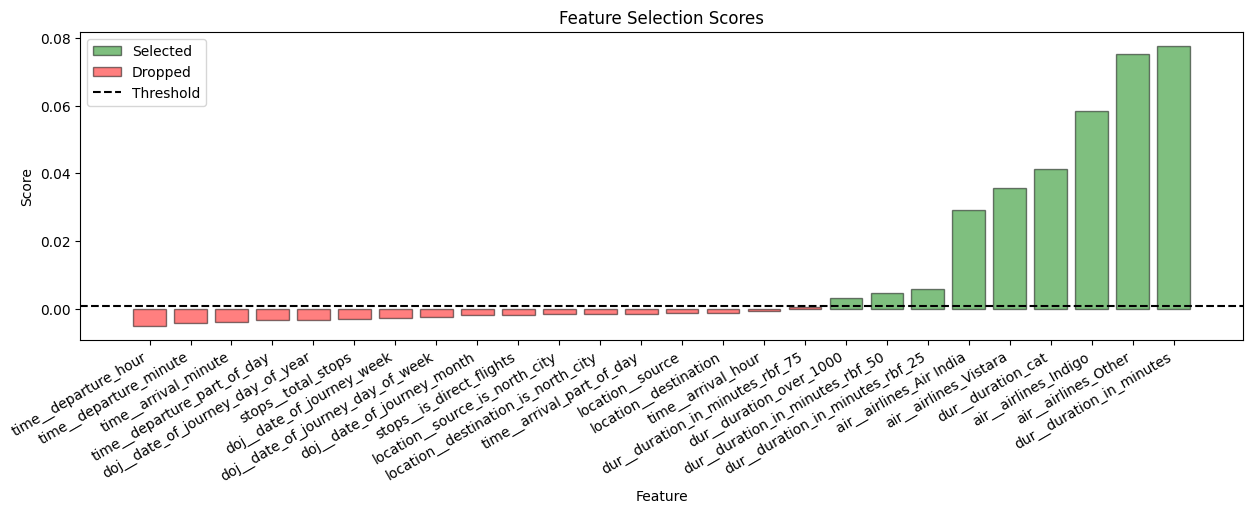

In [105]:
THRESHOLD = 0.001

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.001,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 28 columns after Feature Engineering
- The Feature Selection Algorithm selected 9 features out of that